In [1]:
import numpy as np
from numpy import pi, cos, sin, array, mean

In [2]:
from scipy.linalg import toeplitz

In [3]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [4]:
np.set_printoptions(precision=4)

In [5]:
from warnings import filterwarnings
filterwarnings('ignore', category=UserWarning)

## Convolution

In [6]:
x = np.array([2,2,3, 4, 2,2, 4], np.int)
h = np.array([3,3,2], np.int)

In [7]:
np.convolve(x, h, 'full')

array([ 6, 12, 19, 25, 24, 20, 22, 16,  8])

In [8]:
toeplitz(x, np.zeros_like(h)) @ h

array([ 6, 12, 19, 25, 24, 20, 22])

In [9]:
h_long = np.zeros_like(x)
h_long[:len(h)] = h
toeplitz(h_long, np.zeros_like(x)) @ x

array([ 6, 12, 19, 25, 24, 20, 22])

## Correlation

In [10]:
x = array([1, 1j, -1, -1j])
y = x.copy()
np.correlate(x, y)

array([4.+0.j])

In [11]:
n = np.arange(60)
waveform = 2*cos(2*pi*0.1*n) + cos(2*pi*0.2*n) + 4*cos(2*pi*0.3*n)

In [12]:
signal = cos(2*pi*0.3*n)
np.correlate(waveform, signal)/len(signal)

array([2.])

### Sinusoid of arbitrary phase

In [13]:
waveform = 2*cos(2*pi*0.1*n + pi/4) + cos(2*pi*0.2*n) + 4*cos(2*pi*0.3*n)

In [14]:
signal_i = cos(2*pi*0.1*n)
signal_q = sin(2*pi*0.1*n)

A = 2*np.correlate(waveform, signal_i)/len(signal_i)
B = 2*np.correlate(waveform, signal_q)/len(signal_i)

M = A + B*1j
M = np.squeeze(M)

print(f'Amplitude = {np.abs(M):.1f}  Phase = {-np.angle(M, deg=True):.1f}')

Amplitude = 2.0  Phase = 45.0


### Specialized Codes

In [15]:
B = array([1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1])

In [16]:
SNR = 10 # dB
power_of_B = mean(B**2)

SNR_linear = 10**(SNR/10)
noise_power = power_of_B / SNR_linear
awgn = np.sqrt(noise_power) * np.random.randn(200)

rx_signal = awgn + np.pad(B, (50, 139), 'constant')

In [17]:
corr = np.correlate(rx_signal, B, 'full')

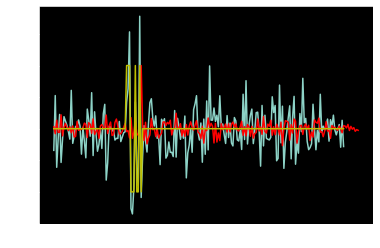

In [18]:
plt.plot(rx_signal);
plt.plot(corr/max(corr), 'r');
plt.plot(rx_signal - awgn, 'y')

In [19]:
C = B[::-1]
shift_register = np.zeros_like(C, np.float)
output = np.zeros_like(rx_signal)

for idx, sample in enumerate(rx_signal):
    shift_register = np.roll(shift_register, 1)
    shift_register[0] = sample
    output[idx] = np.dot(shift_register, C)
    

In [20]:
np.max(corr), np.max(output)

(10.924784722973415, 10.924784722973417)

### Walsh Codes

In [21]:
Walsh = array([[1, 1, 1, 1, 1, 1, 1, 1],
               [1, -1, 1, -1, 1, -1, 1, -1],
               [1, 1, -1, -1, 1, 1, -1, -1],
               [1, -1, -1, 1, 1, -1, -1, 1],
               [1, 1, 1, 1, -1, -1, -1, -1],
               [1, -1, 1, -1, -1, 1, -1, 1],
               [1, 1, -1, -1, -1, -1, 1, 1],
               [1, -1, -1, 1, -1, 1, 1, -1]])
Walsh

array([[ 1,  1,  1,  1,  1,  1,  1,  1],
       [ 1, -1,  1, -1,  1, -1,  1, -1],
       [ 1,  1, -1, -1,  1,  1, -1, -1],
       [ 1, -1, -1,  1,  1, -1, -1,  1],
       [ 1,  1,  1,  1, -1, -1, -1, -1],
       [ 1, -1,  1, -1, -1,  1, -1,  1],
       [ 1,  1, -1, -1, -1, -1,  1,  1],
       [ 1, -1, -1,  1, -1,  1,  1, -1]])

In [22]:
u0_data = array([1, -1, 1])
u1_data = array([-1, -1, 1])
u2_data = array([-1, 1, -1])

In [23]:
user0_data = array([1, -1, 1])
user1_data = array([-1, -1, 1])
user2_data = array([-1, 1, -1])

In [24]:
u0_coded = (user0_data[:, np.newaxis] * Walsh[0]).flatten()
u1_coded = (user1_data[:, np.newaxis] * Walsh[1]).flatten()
u2_coded = (user2_data[:, np.newaxis] * Walsh[2]).flatten()

composite = u0_coded + u1_coded + u2_coded

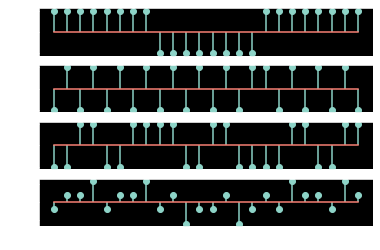

In [25]:
fig, ax = plt.subplots(4, 1); 
ax[0].stem(u0_coded, use_line_collection = True)
ax[1].stem(u1_coded, use_line_collection = True)
ax[2].stem(u2_coded, use_line_collection = True)
ax[3].stem(composite, use_line_collection = True);

In [26]:
u0_correlator = np.correlate(composite, Walsh[0], 'full')
u1_correlator = np.correlate(composite, Walsh[1], 'full')
u2_correlator = np.correlate(composite, Walsh[2], 'full')

In [27]:
u0_decoded = u0_correlator[7::8]/8
u1_decoded = u1_correlator[7::8]/8
u2_decoded = u2_correlator[7::8]/8

decoded_data = np.vstack([u0_decoded, u1_decoded, u2_decoded]).astype(np.int)
decoded_data

array([[ 1, -1,  1],
       [-1, -1,  1],
       [-1,  1, -1]])

#### Auto-correlation

In [28]:
B = array([1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1])
C = array([1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1])

<StemContainer object of 3 artists>

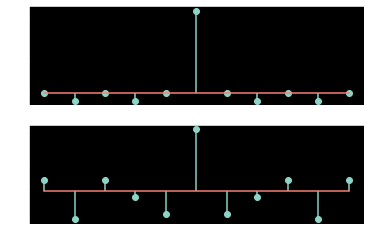

In [29]:
fig, ax = plt.subplots(2, 1)
ax[0].stem(np.correlate(B, B, 'same'), use_line_collection = True)
ax[1].stem(np.correlate(C, C, 'same'), use_line_collection = True)

In [30]:
np.correlate(C, C, 'same')

array([ 2, -5,  2, -1, -4, 11, -4, -1,  2, -5,  2])

In [31]:
np.correlate(B, B, 'same')

array([ 0, -1,  0, -1,  0, 11,  0, -1,  0, -1,  0])

## Fourier Transform

In [32]:
N = 20
n = np.arange(N)

test_seq1 = cos(2*pi*0.1*n)
test_seq2 = np.exp(2j*pi*0.315*n)
test_seq3 = np.exp(2j*pi*0.1*n) + 0.01*np.exp(2j*pi*(-0.25)*n)

In [33]:
def DTFT(test_seq, freq_resolution=0.001):    
    freqs = np.arange(-0.5, 0.5, freq_resolution)
    
    N = len(test_seq)
    n = np.arange(N)

    dtft = np.zeros_like(freqs, np.complex)
    for idx, freq in enumerate(freqs):
        analysis_tone = np.exp(2j*pi*freq*n)
        dtft[idx] = np.correlate(test_seq, analysis_tone).squeeze()/N
        
    return dtft, freqs

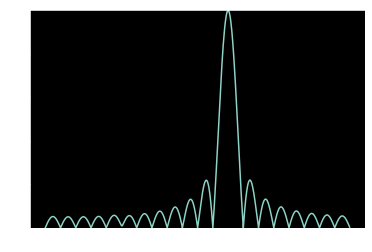

In [34]:
dtft, freqs = DTFT(test_seq3)
magnitude = np.abs(dtft)

plt.plot(freqs, magnitude);
plt.xticks(np.arange(-0.5, 0.6, 0.1));
plt.ylim((0, 1));

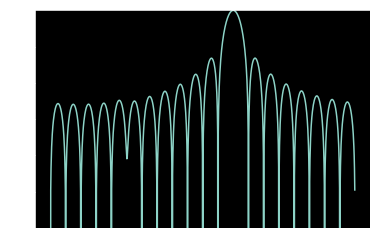

In [35]:
magnitude_db = 20*np.log10(magnitude)
plt.plot(freqs, magnitude_db)
plt.xticks(np.arange(-0.5, 0.6, 0.1));
plt.ylim((-60, 0));

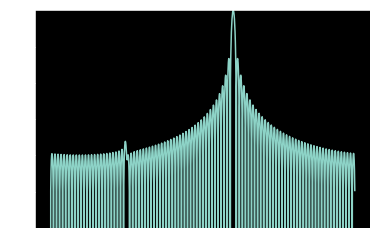

In [36]:
n_long = np.arange(100)
test_seq3_long = np.exp(2j*pi*0.1*n_long) + 0.01*np.exp(2j*pi*(-0.25)*n_long)

dtft, _ = DTFT(test_seq3_long)
magnitude = np.abs(dtft)
magnitude_db = 20*np.log10(magnitude)
plt.plot(freqs, magnitude_db)
plt.xticks(np.arange(-0.5, 0.6, 0.1));
plt.ylim((-60, 0));

#### WIndow

In [37]:
N = 40 
n = np.arange(N)

rectangular = np.ones_like(n)
hanning = (40/20.5)*(0.5 - 0.5*cos( 2*pi*(n+1)/(N+1) ))

test_seq = np.exp(2j*pi*0.1*n) + 0.01*np.exp(-2j*pi*0.25*n)

In [38]:
rect_seq = test_seq*rectangular
dtft_rect, freqs = DTFT(rect_seq, 0.002)
mag_rect = np.abs(dtft_rect)
mag_rect_db = 20*np.log10(mag_rect)

In [39]:
hanning_seq = test_seq*hanning
dtft_hann, freqs = DTFT(test_seq*hanning, 0.002)
mag_hann = np.abs(dtft_hann)
mag_hann_db = 20*np.log10(mag_hann)

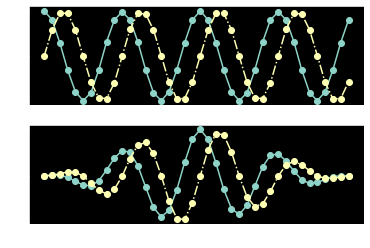

In [40]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(rect_seq.real, '-o')
ax[0].plot(rect_seq.imag, '-.o')

ax[1].plot(hanning_seq.real, '-o')
ax[1].plot(hanning_seq.imag, '-.o');

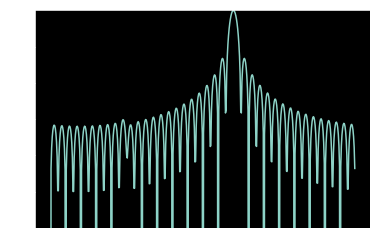

In [41]:
plt.plot(freqs, mag_rect_db)
plt.xticks(np.arange(-0.5, 0.6, 0.1));
plt.ylim((-60, 0));

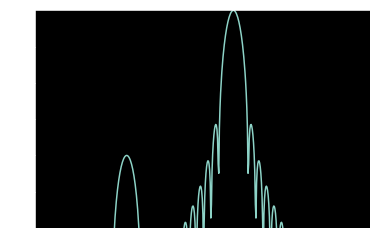

In [42]:
plt.plot(freqs, mag_hann_db)
plt.xticks(np.arange(-0.5, 0.6, 0.1));
plt.ylim((-60, 0));

### DFT

In [43]:
N = 15
n = np.arange(N)
Fs = 1e6
Ts = 1/Fs
f0 = 100e3

test_seq = np.exp(2j*pi*f0*n*Ts)

In [44]:
dft = np.zeros_like(test_seq, np.complex)
for m in np.arange(N):
    analysis_tone = np.exp(2j*pi*n*m/N)
    dft[m] = np.correlate(test_seq, analysis_tone).squeeze()/N


In [45]:
freqs = np.arange(N)*Fs/N
freqs[freqs>=Fs/2] -= Fs

In [46]:
dtft, dtft_freqs = DTFT(test_seq, 0.01)

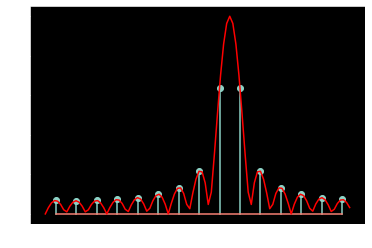

In [47]:
magnitude = np.abs(dft)
plt.stem(freqs, magnitude);
plt.plot(dtft_freqs*Fs, np.abs(dtft), 'r');

### IDFT

In [48]:
N = len(dft)
m = np.arange(N)

idft = np.zeros_like(dft)
for n in np.arange(N):
    tones = np.exp(2j*pi*n*m/N)
    idft[n] = np.sum( dft.dot(tones))

In [49]:
np.max(idft-test_seq)

(2.3314683517128287e-15-7.771561172376096e-16j)

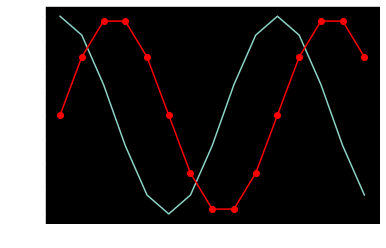

In [50]:
plt.plot(idft.real)
plt.plot(idft.imag, 'r-o');

#### 16-Point DFT using radix-2

In [51]:
def reverse_bit_order(x, num_bits):
    reversed_bits = f'{x:0{num_bits}b}'[::-1]
    return int(reversed_bits, 2)

In [52]:
M = 16
stages = np.log2(M).astype(int)

order = [reverse_bit_order(x, stages) for x in range(M)]

# Test sequence
n = np.arange(M)
f = 0.2
test_seq = cos(2*pi*f*n/1) # Sample rate is 1


# Freqs 
freqs = np.arange(M)/M
freqs[freqs>=1/2] -= 1

In [53]:
memory = np.zeros((M, stages+1), np.complex) # one extra memory bank to store the input
memory[:, 0] = test_seq[order]

# Butterfly calculation
for section in range(1, stages+1):
    N = 2**section # N-point DFT in this section
    blocks = M//N # Number of N-point DFTs
    I = 2**(section-1) # range of i
    
    prev_section = section-1
    for block in range(blocks):
        offset = N*block
        for i in range(I):
            ini = memory[i+offset, prev_section]
            iniN_2 = memory[i+N//2+offset, prev_section]
            Wi = np.exp(-2j*pi*i/N)
            WiN_2 = np.exp(-2j*pi*(i+N/2)/N)
            
            memory[i+offset, section] = ini + Wi * iniN_2
            memory[i+N//2+offset, section] = ini + WiN_2 * iniN_2
        

output = memory[:, stages]/M

In [54]:
dtft, dtft_freqs = DTFT(test_seq)

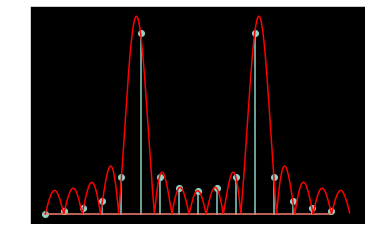

In [55]:
plt.stem( freqs, np.abs(output) );
plt.plot( dtft_freqs, np.abs(dtft), 'r');
plt.xticks(np.arange(-0.5, 0.6, 0.1));